# Comparaison des trois approches

## Librairies

In [21]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import pickle
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from azure.ai.textanalytics import TextAnalyticsClient
from azure.core.credentials import AzureKeyCredential
from azureml.core import Workspace
import warnings
import requests
import json
import tensorflow as tf
from transformers import TFBertForSequenceClassification
from transformers import BertTokenizer

## Settings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
key = os.getenv('KEY')
endpoint = os.environ['ENDPOINT']
sav_path = "./sav/"

## Chargement des données

In [4]:
X = pickle.load(open(sav_path+"X.sav", "rb"))
y = pickle.load(open(sav_path+"y.sav", "rb"))
X_cmp = X["cmp"]
y_cmp = y["cmp"]
del X
del y
print("X_cmp shape : {}".format(X_cmp.shape))
print("y_cmp shape : {}".format(y_cmp.shape))

X_cmp shape : (1600,)
y_cmp shape : (1600,)


## API Azure Cognitive Service

### authentification API 

In [5]:
def authenticate_client():
    ta_credential = AzureKeyCredential(key)
    text_analytics_client = TextAnalyticsClient(
            endpoint=endpoint,
            credential=ta_credential)
    return text_analytics_client

In [6]:
client = authenticate_client()

### Requête

In [7]:
def sentiment_analysis(client, text):
    response = client.analyze_sentiment(documents=text)[0]
    sentiment = 0 if response.confidence_scores.negative > 0.5 else 1
    return sentiment

### Exemple de sentiment positif

In [8]:
sentiment_analysis(client, ["This is so great !"])

1

### Exemple de sentiment négatif

In [9]:
sentiment_analysis(client, ["this is bad"])

0

In [10]:
ls_empty = np.where(X_cmp == "")
X_cmp = np.delete(X_cmp, ls_empty)
y_cmp = np.delete(y_cmp, ls_empty)

In [11]:
y_pred_API = []
for tweet in X_cmp:
    result = sentiment_analysis(client, [tweet])
    y_pred_API.append(result)

### Evaluation sur le jeu de comparaison

#### Matrice de confusion

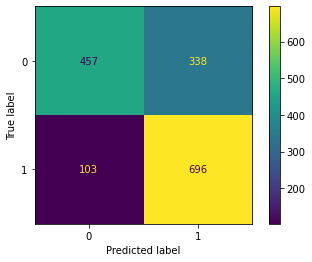

In [86]:
cm = confusion_matrix(y_cmp, y_pred_API)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()

In [88]:
print(classification_report(y_cmp, y_pred_API))

              precision    recall  f1-score   support

           0       0.82      0.57      0.67       795
           1       0.67      0.87      0.76       799

    accuracy                           0.72      1594
   macro avg       0.74      0.72      0.72      1594
weighted avg       0.74      0.72      0.72      1594



#### Accuracy score

In [12]:
accuracy_api = accuracy_score(y_cmp, y_pred_API)
print("Accuracy : ", accuracy_api)

Accuracy :  0.7233375156838143


## Modèle sur mesure simple

### Designer

![](https://i.ibb.co/nbZ1PrK/designer.png)

### Evaluation sur le jeu de comparaison

![](https://i.ibb.co/xDb2d02/designer-06.png)

In [14]:
accuracy_azure_designer = 0.631

## Modèle sur mesure avancé

In [23]:
def load_saved_model(checkpoint_path):
    model = TFBertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=2
    )
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True
    )
    metric = tf.keras.metrics.SparseCategoricalAccuracy(
        'accuracy'
    )
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=2e-5,
        epsilon=1e-08
    )
    model.compile(
        loss=loss,
        optimizer=optimizer,
        metrics=[metric]
    )
    model.load_weights(checkpoint_path)
    return model

MAX_LEN = 128
def tokenize(tweets):
    input_ids=[]
    attention_masks=[]
    for tweet in tweets:
        bert_inp=bert_tokenizer.encode_plus(
            tweet,
            add_special_tokens=True,
            max_length=MAX_LEN,
            pad_to_max_length=True,
            return_attention_mask=True
        )
        input_ids.append(bert_inp["input_ids"])
        attention_masks.append(bert_inp["attention_mask"])
    inputs_ids = np.array(input_ids)
    attention_masks = np.array(attention_masks)
    return input_ids, attention_masks

In [28]:
loaded_model = load_saved_model(sav_path+'BERT_WEIGHTS/bert_model_weights')
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
X = pickle.load(open(sav_path+"X.sav", "rb"))
y = pickle.load(open(sav_path+"y.sav", "rb"))

In [26]:
for dataset in X:
    ls_empty = np.where(X[dataset] == "")
    X[dataset] = np.delete(X[dataset], ls_empty)
    y[dataset] = np.delete(y[dataset], ls_empty)

In [29]:
input_ids = []
attention_masks = []

input_ids, attention_masks = tokenize(
    X["cmp"]
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [30]:
result_loaded_model = loaded_model.predict(
    [
        np.array(input_ids),
        np.array(attention_masks)
    ]
)

50/50 [==============================] - 119s 2s/step


In [31]:
y_pred_loaded_model = np.argmax(result_loaded_model["logits"], axis=1)

In [32]:
accuracy_bert = accuracy_score(y["cmp"], y_pred_loaded_model)
print("Accuracy : ", accuracy_bert)

Accuracy :  0.7998745294855709


## Comparaison des 3 modèles

In [33]:
app = [
    'API_sur_étagère', 
    'Modèle_sur_mesure_simple', 
    'Modèle_sur_mesure_avancé'
]
accuracy = [
    accuracy_api, 
    accuracy_azure_designer, 
    accuracy_bert
]
x=[0,1,2]

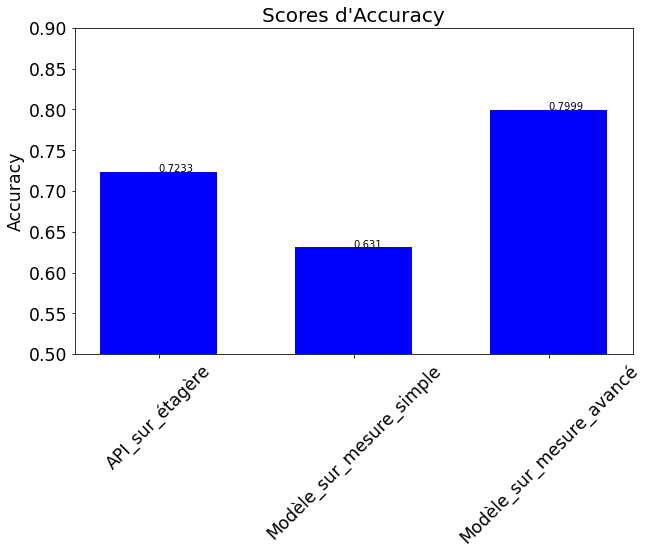

In [7]:
def addlabels(x,y,decimals):
    for i in range(len(x)):
        plt.text(i,y[i],round(y[i], decimals))

plt.figure(figsize=(10,6))
plt.bar(
    x, 
    accuracy, 
    0.6, 
    color='b'
)
plt.title(
    "Scores d'Accuracy", 
    fontsize=20
)
plt.xticks(
    range(len(app)), 
    app, 
    size='xx-large', 
    rotation=45
)

addlabels(x, accuracy, 4)

plt.ylabel(
    "Accuracy", 
    size='xx-large'
)
plt.yticks(size='xx-large')
plt.ylim(0.5, 0.9)

plt.show()